In [ ]:
from IPython.display import clear_output

!pip install datasets transformers rouge_score nltk
!pip install pyarrow
# !pip install -q sentencepiece
# !pip install rouge-score # google package version

clear_output()

In [ ]:
import os
import re
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

# nlp stuff
import nltk

# tf stuff
import tensorflow_datasets as tfds 
import tensorflow as tf
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration # pegasus
from transformers import BartTokenizer, TFBartForConditionalGeneration # bart

# pytorch dataset types
import datasets
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, load_metric, load_dataset

# pytorch bart stuff
import torch
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import AutoTokenizer

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load data

Start by loading into pandas

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path ="/content/gdrive/MyDrive/Classes/W266_NLP/w266_reddit_summarization/data/reddit_parquet/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir(data_path)
files = [i for i in os.listdir(data_path) if re.search("reddit_data", i)]

In [ ]:
df = pd.read_parquet(files[:3])

Count vocab

In [ ]:
def count_vocab(item):
  return len(set(item.split(" ")))

df['content_vocab'] = df['content'].map(count_vocab)
df['summary_vocab'] = df['summary'].map(count_vocab)

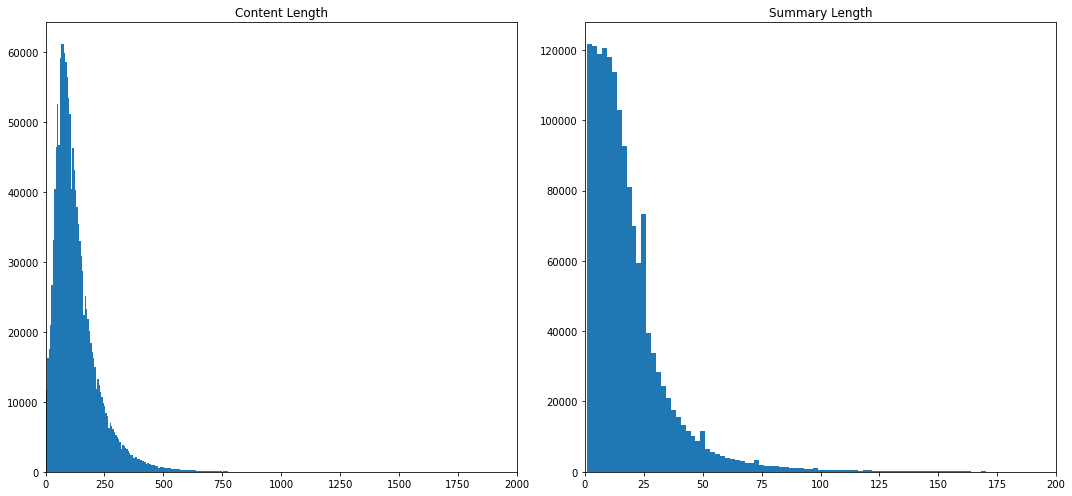

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15,7)) 

ax[0].hist(df['content_vocab'], bins=200)
ax[0].set_xlim(0, 2000)
ax[0].title.set_text("Content Length")

ax[1].hist(df['summary_vocab'], bins=300)
ax[1].set_xlim(0, 200)
ax[1].title.set_text("Summary Length")

fig.tight_layout()

Create subreddit groupings. (Work more on this later)

In [ ]:
df_subreddit = df['subreddit'].value_counts().reset_index().rename(columns={"index": "subreddit", "subreddit": "N"})
df_subreddit

,subreddit,N
0,AskReddit,350277
1,leagueoflegends,36728
2,AdviceAnimals,27997
3,funny,26517
4,pics,24194
...,...,...
14819,Anthroposophy,1
14820,TagProConspiracies,1
14821,DPSdolls,1
14822,ubcengineering,1


In [ ]:
subreddit_i = 'rpg'
ind = 4
print('post')
pprint(df.loc[df['subreddit'] == subreddit_i].iloc[ind,0])
print("\nSummary")
pprint(df.loc[df['subreddit'] == subreddit_i].iloc[ind,1])

post
('I create a setting, and I adjust it as I go to what  my particular players  '
 'want out of the game, both for themselves and for their characters.  I then '
 'have the actors in my world respond to the actions the characters take over '
 'the course of their adventures, i.e., I bring about natural consequences. \n'
 ' Sometimes these consequences are harsh. \n'
 ' I am not trying to kill the characters.  That would be way too easy.  I try '
 'to create balanced encounters that the characters  should  be able to '
 'survive, and then I have the creatures/traps/whatever try their hardest to '
 'kill the characters to the best of their abilities. \n'
 ' Along the way, I adjust on the fly behind the screen if it appears that '
 "I've made the encounter way too difficult, or if I sense that I allowed the "
 'players to get themselves into a predicament that they might not have gotten '
 'themselves into had I presented the warning signs better. In short, if it is '
 "clearly my faul

In [ ]:
def group_subreddit(subreddit):

  if subreddit in ['buildapc', 'LifeProTips', 'IAmA', 'DoesAnybodyElse',
                   ] or re.search('advice|ask|relationship|explain|question', subreddit.lower()):
    x = 'advice'
  elif subreddit in ['leagueoflegends', 'DotA2', 'starcraft', 'magicTCG', 
                     'Guildwars2', 'DestinyTheGame', 'pcmasterrace', 
                     'Planetside', 'rpg', 'pokemon', 'smashbros', 'swtor', 
                     'runescape', 'battlefield3', 'DarkSouls2', 'LeagueofLegendsMeta', 
                     'WorldofTanks', 'darksouls', 'gamedev', 'Minecraft', 'Diablo', 
                     'DnD', 'skyrim', 'halo', 'PS4', 'xboxone', 'battlefield_4', 
                     'ShouldIbuythisgame', 'Pathfinder_RPG', 'elderscrollsonline', 
                     'Fallout', 'GrandTheftAutoV'
                     ] or re.search('gaming|games', subreddit.lower()):
    x = 'gaming'
  elif subreddit in ['tifu', 'TwoXChromosomes', 'offmychest', 'todayilearned', 
                     'fffffffuuuuuuuuuuuu', 'TalesFromRetail', 'JusticePorn', 
                     'confession']:
    x = 'story'
  elif re.search('funny|comedy', subreddit.lower()):
    x = 'comedy'
  elif subreddit in ['changemyview'] or re.search('news|politic|atheis|religion|christian|islam|mormon', subreddit.lower()):
    x = 'news/life'
  elif re.search('sport|baseball|soccer|golf|football|basketball|nfl|nba|mlb', subreddit.lower()):
    x = 'sports'
  elif re.search('pics|videos', subreddit.lower()):
    x = 'pics/videos'
  else:
    x = 'other'
  
  return x

In [ ]:
df['subreddit'].map(group_subreddit).value_counts()

other          660543
advice         472590
gaming         152872
news/life       89163
pics/videos     40168
story           37623
comedy          26635
sports          20406
Name: subreddit, dtype: int64

In [ ]:
from IPython.display import display, HTML

df_subreddit['category'] = df_subreddit['subreddit'].map(group_subreddit)
df_subreddit = df_subreddit[df_subreddit['category'] == 'other']

# Puts the scrollbar next to the DataFrame
display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" +
             df_subreddit.to_html() +
             "</div>"))

In [ ]:
df['subreddit_group'] = df['subreddit'].map(group_subreddit)

# BART

In [ ]:
# download model and tokenizer
model_checkpoint = 'facebook/bart-base' 
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/532M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['content', 'summary', 'subreddit', 'subreddit_group']], test_size=0.2, random_state=1)
train

,content,summary,subreddit,subreddit_group
673634,"The Business Insider article asks ""Why does it...",Google is a purpose oriented company and that ...,todayilearned,story
40086,"Win rates do mean a lot, it's just easy to mis...",u/Kangarou cited a champion win rate focused o...,summonerschool,other
556764,"It's an awareness day! For fuck's sake, of co...",Please stop with the male HIV/AIDS focus. Tha...,MensRights,other
1117076,I get this for the single mothers that use it ...,"Shut up, you entitled childless brat who has b...",AdviceAnimals,advice
1070717,Me and a friend did this to a guy in detention...,"Tied some guys bag to the desk in detention, w...",funny,comedy
...,...,...,...,...
836489,Nate Thurmond played 1.5 seasons with the Cava...,"Yes, they should retire his number.",nba,sports
491263,"Thanks for the credit, man! I appreciate it wh...","thanks four24ever, you're a good sir!",AdviceAnimals,advice
470924,You are alive. The odds of you (specifically) ...,Go read a fucking book. Learn something and ap...,cripplingalcoholism,other
491755,This is a reselling of a cousin's story. I wil...,Sparky booby trapped switches with poop.,AskReddit,advice


In [ ]:
all_data = DatasetDict({
    'train': Dataset.from_dict({
        'content': train['content'],
        'summary': train['summary'],
        'subreddit': train['subreddit'],
        'subreddit_group': train['subreddit_group']
    }),

    'test': Dataset.from_dict({
        'content': test['content'],
        'summary': test['summary'],
        'subreddit': test['subreddit'],
        'subreddit_group': test['subreddit_group']
    })
    
})

all_data

DatasetDict({
    train: Dataset({
        features: ['content', 'summary', 'subreddit', 'subreddit_group'],
        num_rows: 1200000
    })
    test: Dataset({
        features: ['content', 'summary', 'subreddit', 'subreddit_group'],
        num_rows: 300000
    })
})

In [ ]:
# free up memory by removing old objects
del df, df_subreddit, train, test

In [ ]:
# tokenize summary and content
max_input_length = 1024
max_target_length = 128

# if we're using t5, append "summarize: " in front
if model_checkpoint in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

def preprocess_function(examples, xvar='content', yvar='summary', max_input_length=1024, max_target_length=128):
    inputs = [prefix + doc for doc in examples[xvar]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples[yvar], max_length=max_target_length, truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# now tokenize our data
all_data_tokenized = all_data.map(preprocess_function, batched=True)

Parameter 'function'=<function preprocess_function at 0x7f0d578b3b90> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/300 [00:00<?, ?ba/s]

In [ ]:
# now the content is converted to 'input_ids' and 'attention_mask'.
# and 'summary' is converted to 'lables'
all_data_tokenized

DatasetDict({
    train: Dataset({
        features: ['content', 'summary', 'subreddit', 'subreddit_group', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1200000
    })
    test: Dataset({
        features: ['content', 'summary', 'subreddit', 'subreddit_group', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 300000
    })
})

In [ ]:
# set hyperparms
args = Seq2SeqTrainingArguments(
    output_dir = 'finetuned_bart_v1', # file path to save checkpoints of the model. 
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3, # only make 3 checkpoint saves maximum through training process. 
    num_train_epochs=1,
    predict_with_generate=True, # use this to predict summaries. 
    # fp16=True, # default is false, whether to use 16-bit precision training instead of 32. Can only be used w/ CUDA error (gpu). 
    # push_to_hub=True,
)

# define how to compute metrics from preds. 
# We'll use rouge from the 'metric' object we defined above
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

# need this collator to pad the examples
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
all_data_tokenized_train = all_data_tokenized['train']
all_data_tokenized_test = all_data_tokenized['test']

all_data_tokenized_train['subreddit_category'] == 'sports'

In [ ]:
# filter data on a subreddit category
from torch.utils.data import Subset

train_idx = np.where((train_dataset.targets==0))[0]

train_subset = Subset(train_dataset, train_idx)
train_loader_subset = DataLoader(train_subset, shuffle=True, batch_size=batch_size)